# Star Wars Exploration
## Part A - Generische Community-Analyse



In [1]:
# Import
import os
import json
import community
import numpy as np
import pandas as pd
import nxviz as nxv
import networkx as nx  #NetworkX provides basic functionality for visualizing graphs, but its main goal is to enable graph analysis rather than perform graph visualization.
import seaborn as sns
import matplotlib.pyplot as plt
import random

ModuleNotFoundError: No module named 'community'

## 1. Data Load
### 1.1 load all titles

In [ ]:
#DATA_PATH = './data'
#FILES = dict()
#for file_name in os.listdir(DATA_PATH):
    #if file_name.startswith('gender_mapping'):
        #continue
    #full_file_path = os.path.join(DATA_PATH, file_name)
    #FILES[os.path.splitext(file_name)[0]] = full_file_path

DATA_PATH = './data'
FILES = dict()
for file_name in os.listdir(DATA_PATH):
    full_file_path = os.path.join(DATA_PATH, file_name)
    FILES[os.path.splitext(file_name)[0]] = full_file_path


Fazit: We have various files. Per episode interactions or mentions and also a complete aggregation.

### 1.2 Loading a specific file: Starwars full interactions (Combination episode 1-7)

In [ ]:
with open(FILES['starwars-full-interactions-allCharacters']) as f:
    data_allep = json.load(f)

### 1.3 Loading a interaction-files: Individuals episodes


In [ ]:
for x in range(1,8):
    filename = f'starwars-episode-{x}-interactions'  # "-allCharacters"

    with open(FILES[filename]) as f:
        globals()['data_ep%s' % x] = json.load(f)

## 2. Building Graph
### 2.1 Definition of a general Graph-Function 


In [ ]:
def make_graph(dataset, nodes, edges):
    G = nx.Graph()
    for node in nodes:
        G.add_node(node['name'], **dict(zip(node.keys(),node.values())))
    for edge in dataset['links']:
        G.add_edge(dataset['nodes'][edge['source']]['name'], dataset['nodes'][edge['target']]['name'], **dict(zip(edge.keys(),edge.values())))
    return G


### 2.2 Graph for full Dataset (1-7)

In [ ]:
universe_allep = make_graph(data_allep, data_allep['nodes'], data_allep['links'])
#print(nx.info(universe_allep))


### 2.3 Graphs for each episode

In [ ]:
universe_ep1 = make_graph(data_ep1, data_ep1['nodes'], data_ep1['links'])
universe_ep2 = make_graph(data_ep2, data_ep2['nodes'], data_ep2['links'])
universe_ep3 = make_graph(data_ep3, data_ep3['nodes'], data_ep3['links'])
universe_ep4 = make_graph(data_ep4, data_ep4['nodes'], data_ep4['links'])
universe_ep5 = make_graph(data_ep5, data_ep5['nodes'], data_ep5['links'])
universe_ep6 = make_graph(data_ep6, data_ep6['nodes'], data_ep6['links'])
universe_ep7 = make_graph(data_ep7, data_ep7['nodes'], data_ep7['links'])


## 3. network analysis
In a modular network, a node has two types of influence: 
- a local influence (on the nodes in its community) through its intra-community connections 
- and a global influence (on the nodes in other communities) through its intra-community connections. 

Depending on the strength of the community structure, these two components are more or less influential.

**Subnetwork forms**
- It is possible that two subnetworks (communities) are connected to each other via a bridge (in our case cross-community interactions). However, it is also possible that a cluster has no connection to other clusters.
- A figure alone can also represent a subnetwork/have no interaction with other figures. I.e. there is no information flow

**1. modularity: **
- Modularity measures the degree to which a network is divided into communities (clusters).
- Low modularity is associated with heterogeneous connectivity patterns over time.
- Networks with high modularity have *dense connections* between the nodes *within clusters*, but *sparse connections* between nodes in different communities.  
- In a highly interconnected system with low modularity, a shock to one compartment can cascade into another compartment, increasing the risk of system-wide collapse. 
- Conversely, in a system with a high degree of modularity, a disruption to one component can be better contained, 
and it is less likely that the disruption will spread to other components. 
- A large Q indicates a good community structure.
- Procedure: Compute the partition of the graph nodes which maximises the modularity

**2. betweenness centrality: ** *(High relevance to our question)*.
- This measure shows which nodes are 'bridges' between nodes in a network. 
- The measure of centrality is based on shortest paths.
- Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes.
- This figure is importent for the communication between 2 Communtities (Network broker)


**3. Degree Centrality: ** *(Less relevance for our questions)*
- Historically first and conceptually simplest is degree centrality, which is defined as the number of links incident upon a node 
- how much each actor is “in the center” of a network is one of the key concepts in network analysis
- The degree can be interpreted in terms of the immediate risk of a node for catching whatever is flowing through the network (such as a virus, or some information). 
- The figure with the most connections to other people. (Within a Subnetwork)

### 3.1 Composition & forms of the Communities (Subnetworks) in the Star Wars

In the following, the best communities partitions are searched with using "modularity".

#### 3.1.1 Community (Subnetwork)-Analysis: Over all episodes 

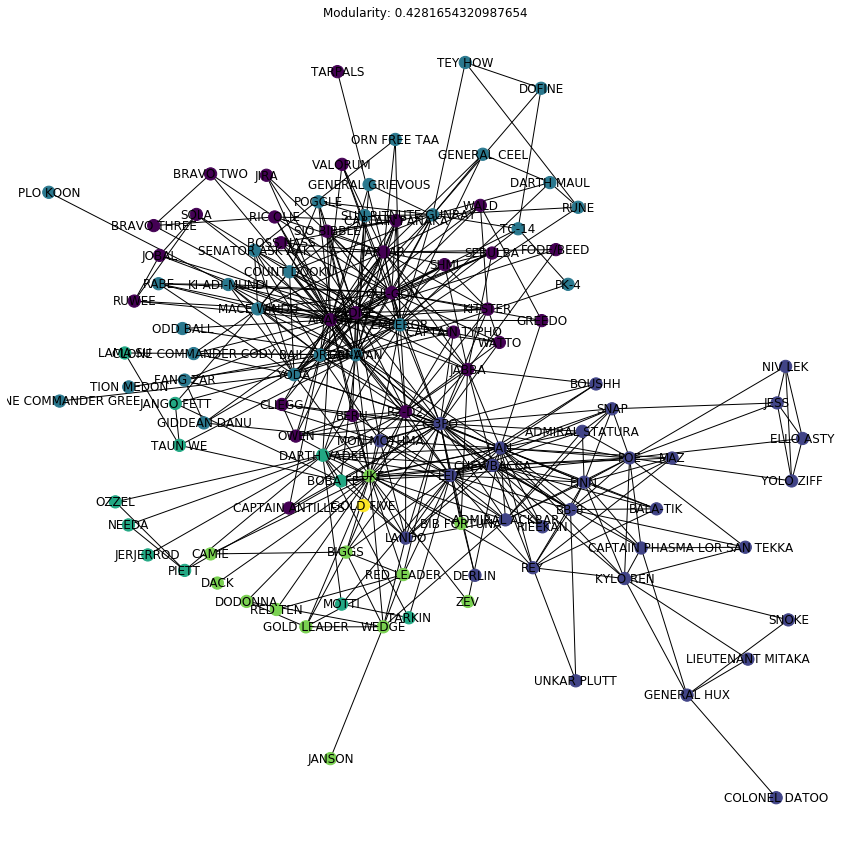

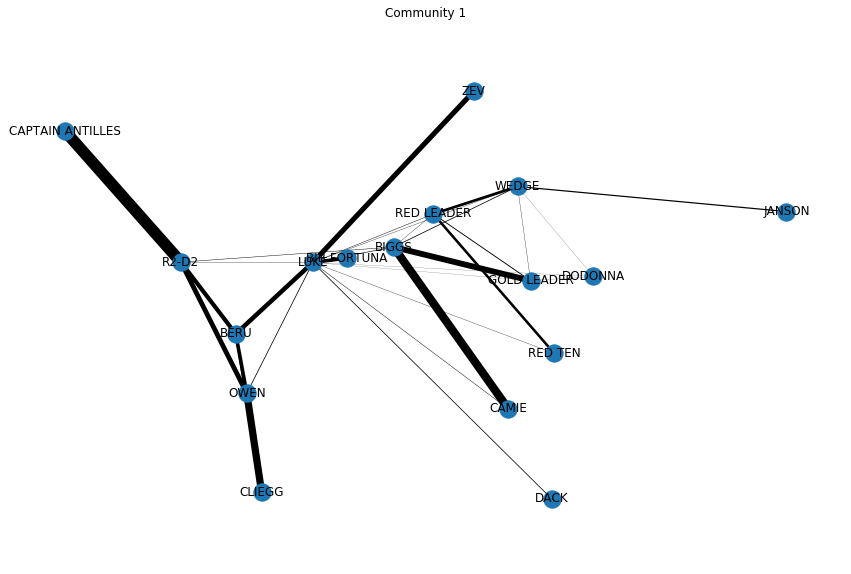

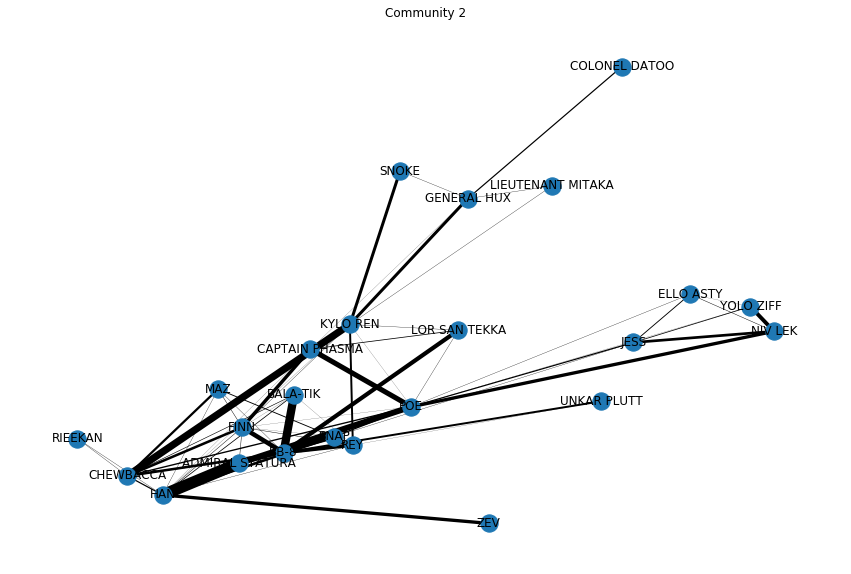

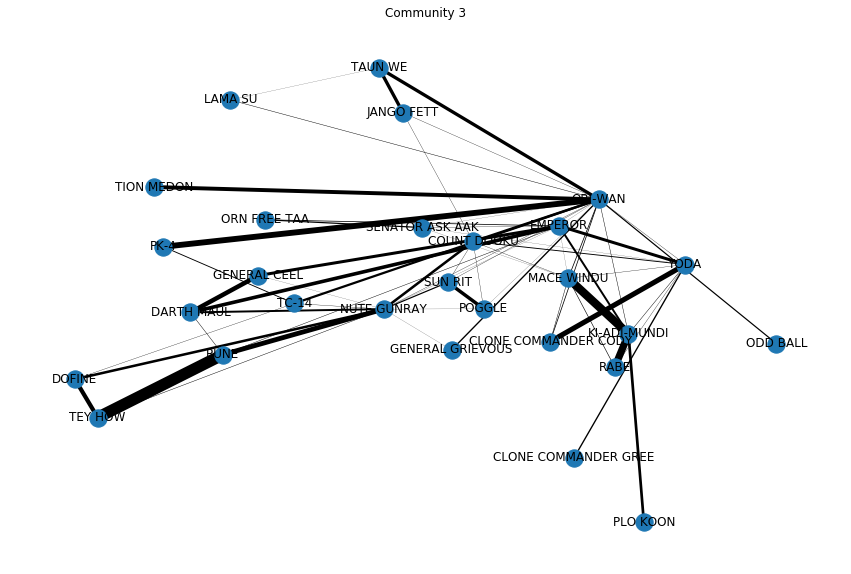

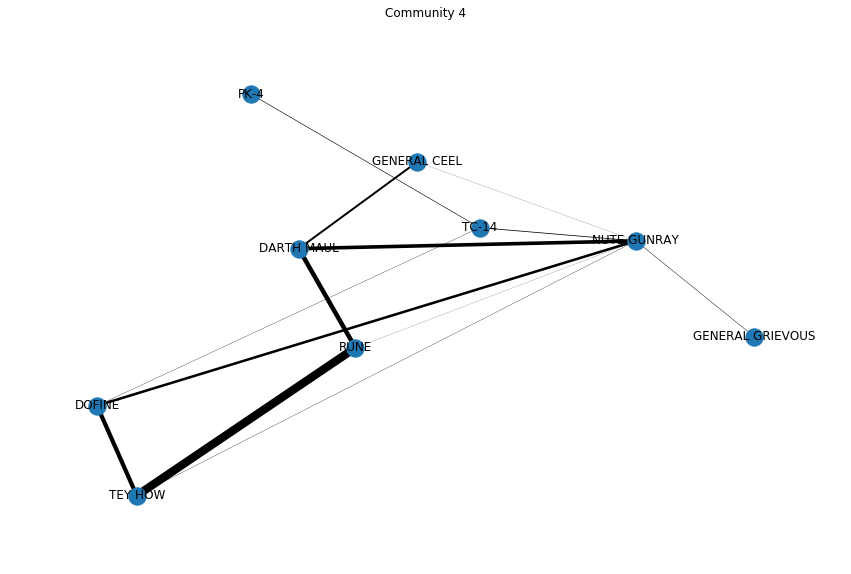

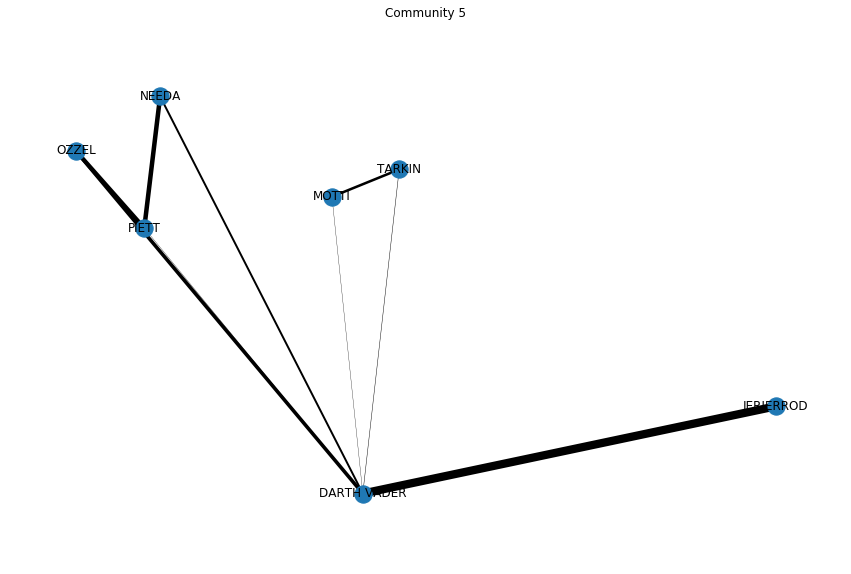

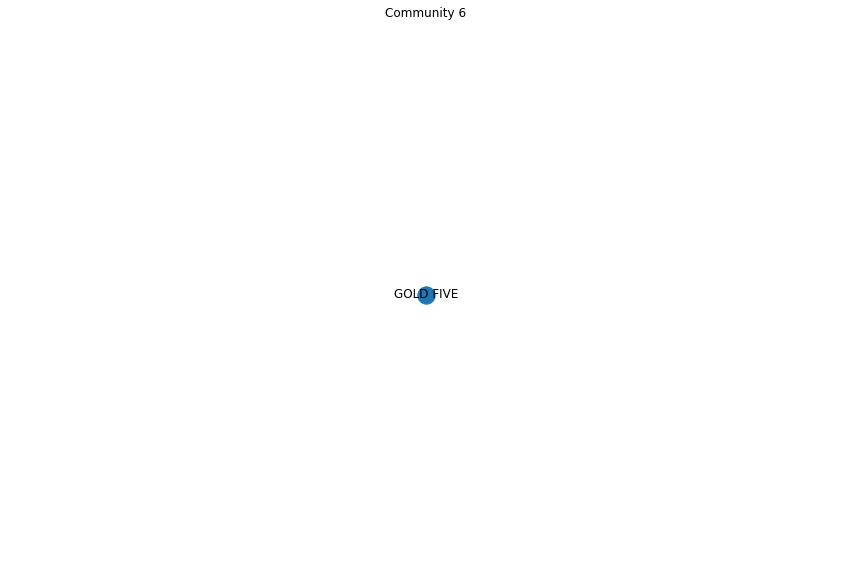

In [ ]:
random.seed(1)

coords0 = nx.kamada_kawai_layout(universe_allep)
comm_all = community.best_partition(universe_allep)
mod_all = community.modularity(comm_all, universe_allep)

options = {
    'node_color': list(comm_all.values()),
    'node_size': 150,
    'width': 1,
    'with_labels': True,
    'pos': coords0
}

plt.figure(figsize=(15,15))
plt.title(f'Modularity: {mod_all}')
nx.draw(universe_allep, **options)

###------ Analyse der einzelnen Communities

edge_weights = list()
for (_, _, d) in universe_allep.edges(data=True):
    edge_weights.append(d['value'])

pos = nx.spring_layout(universe_allep)

for comm_num in np.unique(list(comm_all.values())):
    partition = community.best_partition(universe_allep)
    partition_nodes = list()
    for node, c in partition.items():
        if c == comm_num:
            partition_nodes.append(node)
        else:
            partition[node] = -1
    sub_universe = universe_allep.subgraph(partition_nodes)
    edge_widths = (edge_weights / np.quantile(edge_weights, 0.85)).tolist()
    
    
    # Plot
    fig, ax = plt.subplots(figsize=(15,10))
    nx.draw(sub_universe, pos, with_labels=True, width=edge_widths)
    ax.set_title(f'Community {comm_num+1}');


In [ ]:
# Calculate Degree Centrality

degreeCent = nx.degree_centrality(universe_allep)
#print(degreeCent)
sorted(degreeCent, key=degreeCent.get, reverse=True)[:5]

['ANAKIN', 'OBI-WAN', 'C-3PO', 'PADME', 'QUI-GON']

In [ ]:
# Calculate Betweenness Centrality

betCent = nx.betweenness_centrality(universe_allep)
#print(betCent)
sorted(betCent, key=betCent.get, reverse=True)[:5]



['OBI-WAN', 'C-3PO', 'ANAKIN', 'LUKE', 'HAN']

**Allgemein:** ANAKIN,OBI-WAN,C-3PO,PADME,QUI-GON are the five figures with the most interactions (Degree Centrality)

**Descriptive Interpretation 
** 
- Partitions: 6 communities are recognisable. Gold Five is a cluster of its own, i.e. this figure does not interact personally with other figures.
- Hint: The subnetworks are not symmetrical. Figures with many interactions are not necessarily in the middle of the community.

**Interpretation Connections between communities (Modularity & Betweenness centrality)**
- The modularity of 0.42 is rather low. This means that the connections within the communities are not particularly dense. 
- Because of that the communities are strongly interconnected,and effects in one community have a strong impact on the other communities.
- Betweenness Centrality: OBI-WAN,C-3PO, ANAKIN, LUKE, HAN are important players between the networks. 
  They play an important role in cross-community communication.




![Picture title](image-20201210-212106.png)

### Network-Analysis: Episode IV (4) – A New Hope (1977)

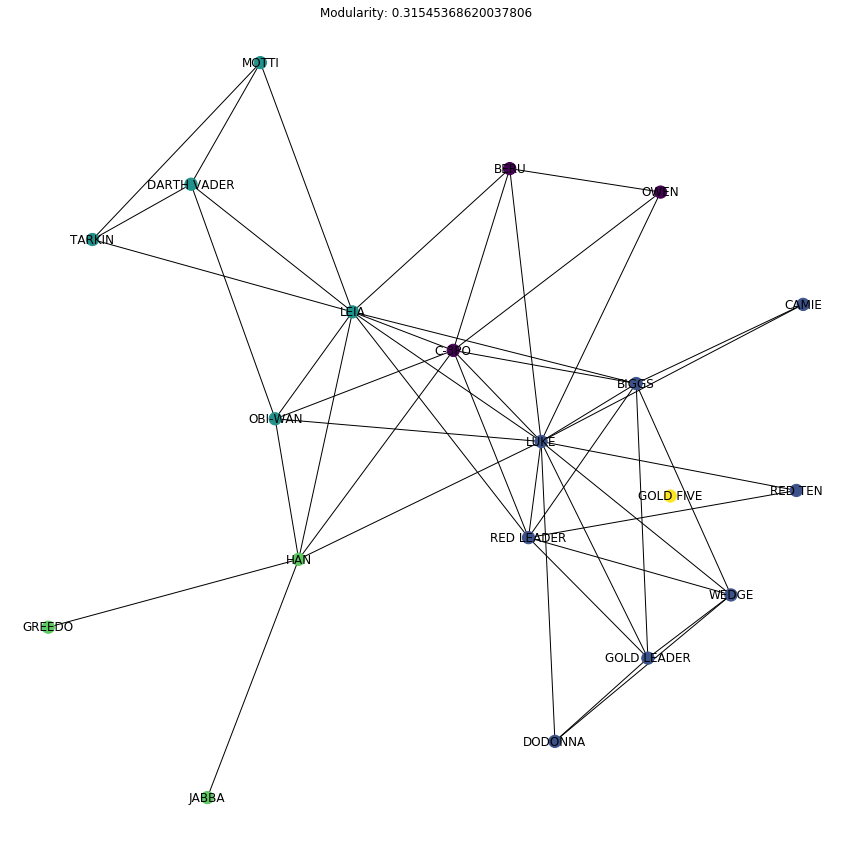

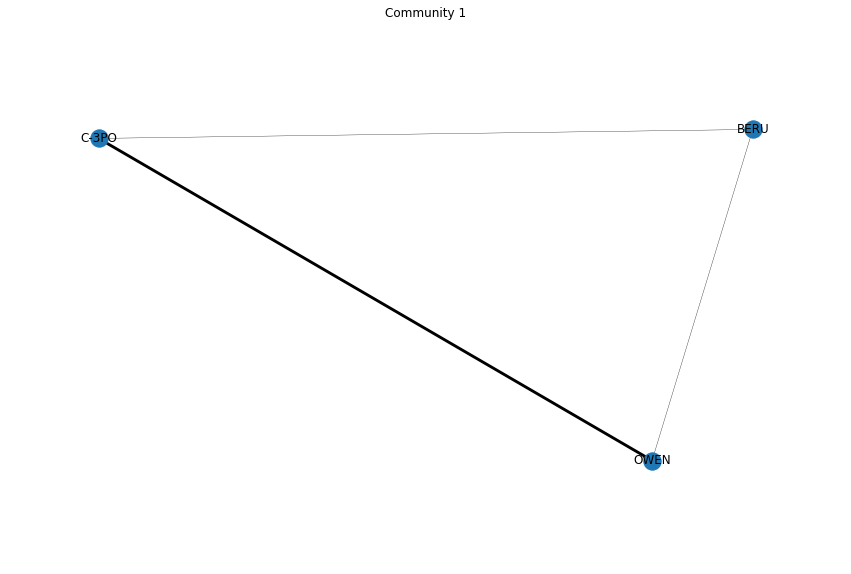

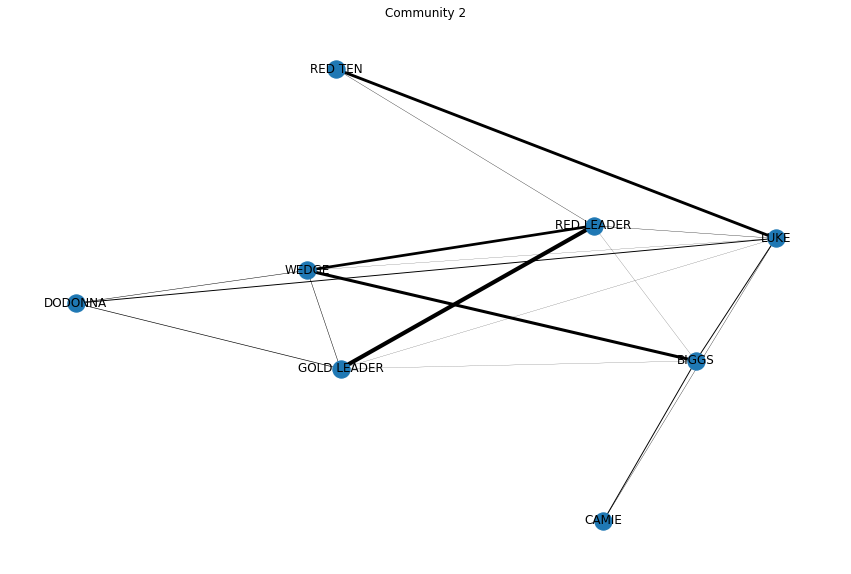

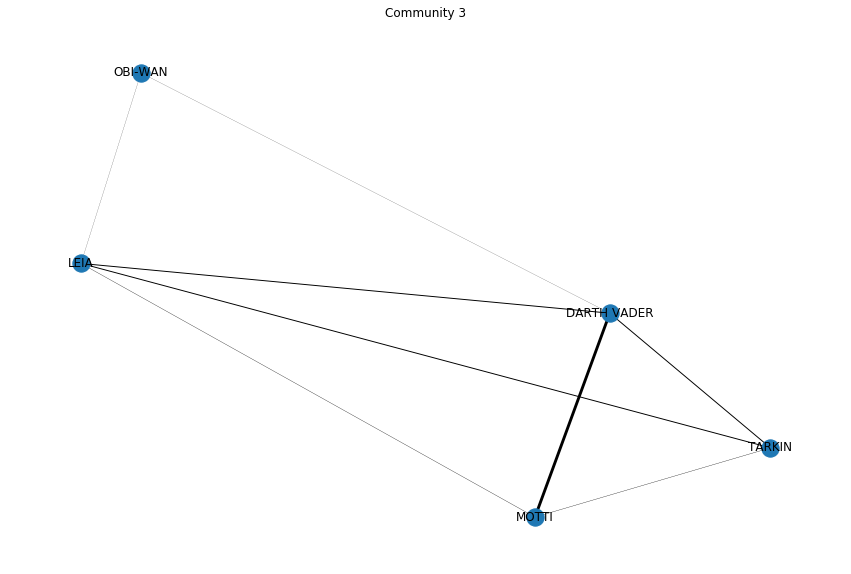

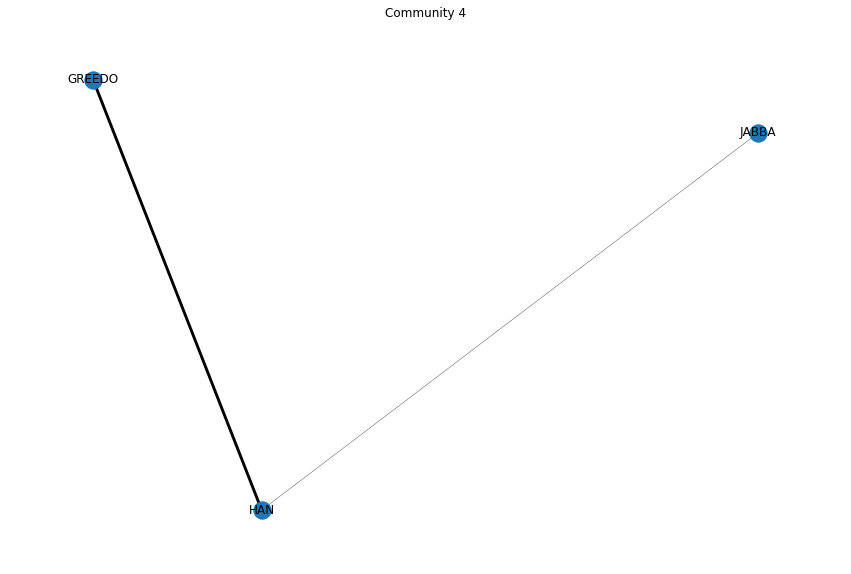

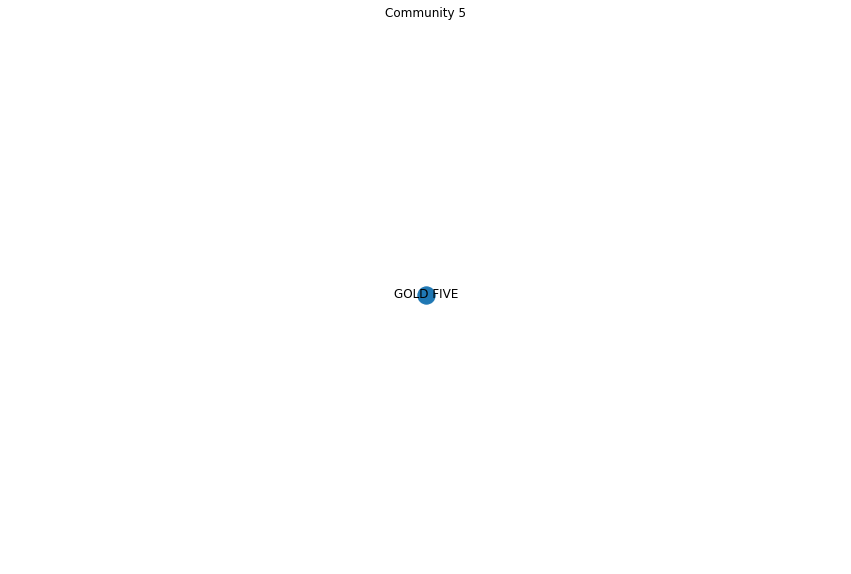

In [ ]:
random.seed(1)

coords4 = nx.kamada_kawai_layout(universe_ep4)
comm_all4 = community.best_partition(universe_ep4)
mod_all4 = community.modularity(comm_all4, universe_ep4)


options = {
    'node_color': list(comm_all4.values()),
    'node_size': 150,
    'width': 1,
    'with_labels': True,
    'pos': coords4
}

plt.figure(figsize=(15,15))
plt.title(f'Modularity: {mod_all4}')
nx.draw(universe_ep4, **options)

###------

edge_weights = list()
for (_, _, d) in universe_ep4.edges(data=True):
    edge_weights.append(d['value'])

pos = nx.spring_layout(universe_ep4)

for comm_num in np.unique(list(comm_all4.values())):
    partition = community.best_partition(universe_ep4)
    partition_nodes = list()
    for node, c in partition.items():
        if c == comm_num:
            partition_nodes.append(node)
        else:
            partition[node] = -1
    sub_universe = universe_ep4.subgraph(partition_nodes)
    edge_widths = (edge_weights / np.quantile(edge_weights, 0.85)).tolist()
    # Plot
    fig, ax = plt.subplots(figsize=(15,10))
    nx.draw(sub_universe, pos, with_labels=True, width=edge_widths)
    ax.set_title(f'Community {comm_num+1}');

In [ ]:
# Calculate Degree Centrality

degreeCent = nx.degree_centrality(universe_ep4)
#print(degreeCent)
sorted(degreeCent, key=degreeCent.get, reverse=True)[:5]

['LUKE', 'LEIA', 'C-3PO', 'BIGGS', 'RED LEADER']

In [ ]:
# Calculate Betweenness Centrality

betCent = nx.betweenness_centrality(universe_ep4)
#print(betCent)
sorted(betCent, key=betCent.get, reverse=True)[:5]


['LUKE', 'LEIA', 'HAN', 'C-3PO', 'RED LEADER']

**Allgemein:** 'LUKE', 'LEIA', 'C-3PO', 'BIGGS', 'RED LEADER' are the five figures with the most interactions.

**Interpretation Form of communities (Anz. Partitions)** 
- Partitions: 5 communities are recognisable. 
- Hint: No symmetrical shape.

**Interpretation Connections between communities (Modularity & Betweenness centrality)**
- The modularity is rather low at 0.31. The connections within the clusters are rather weak. A low Q indicates a low community structure.
- Betweenness Centrality: 'LUKE', 'LEIA', 'HAN', 'C-3PO', 'RED LEADER'




### Network-Analysis: Episode V – The Empire Strikes Back (1980) - 5

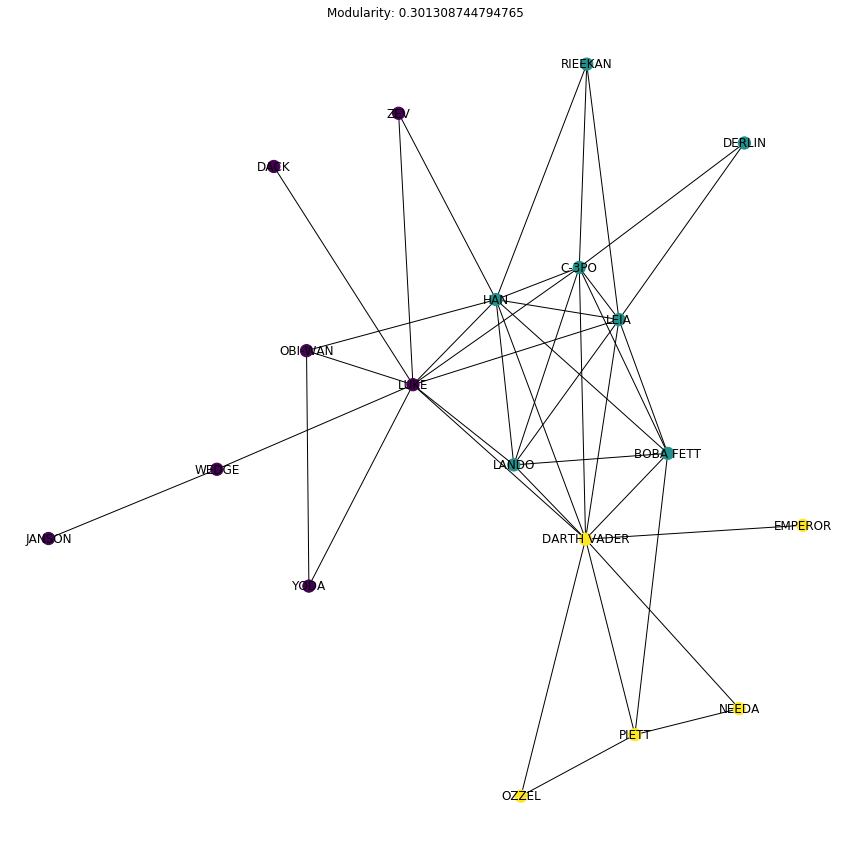

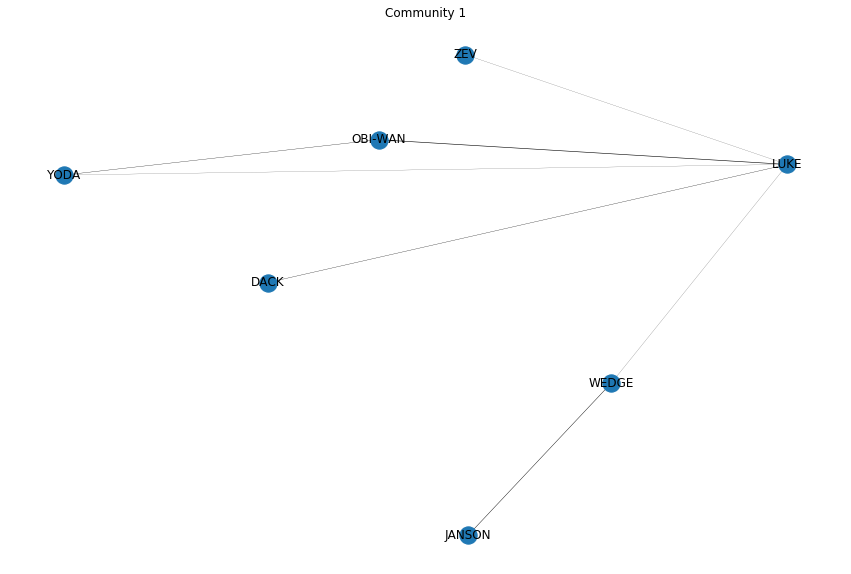

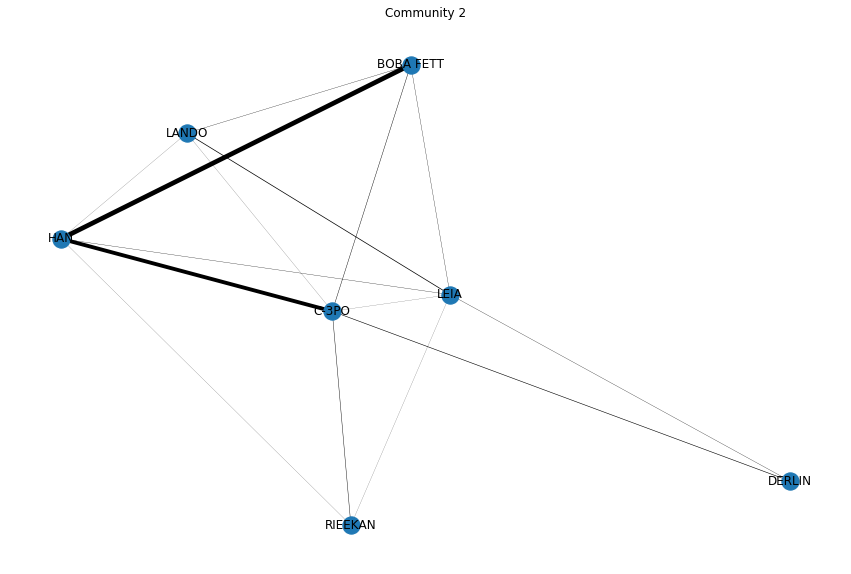

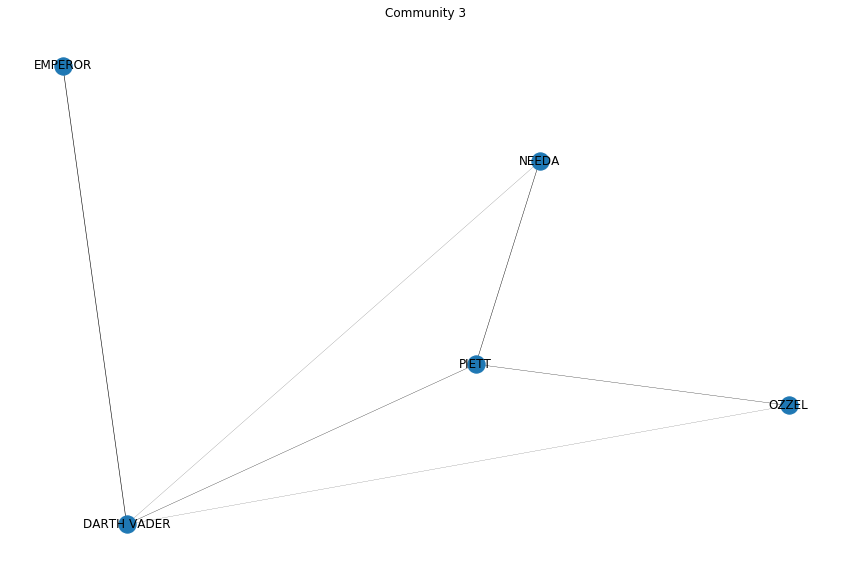

In [ ]:
random.seed(1)

coords5 = nx.kamada_kawai_layout(universe_ep5)
comm_all5 = community.best_partition(universe_ep5)
mod_all5 = community.modularity(comm_all5, universe_ep5)

options = {
    'node_color': list(comm_all5.values()),
    'node_size': 150,
    'width': 1,
    'with_labels': True,
    'pos': coords5
}

plt.figure(figsize=(15,15))
plt.title(f'Modularity: {mod_all5}')
nx.draw(universe_ep5, **options)

###------

edge_weights = list()
for (_, _, d) in universe_ep5.edges(data=True):
    edge_weights.append(d['value'])

pos = nx.spring_layout(universe_ep5)

for comm_num in np.unique(list(comm_all5.values())):
    partition = community.best_partition(universe_ep5)
    partition_nodes = list()
    for node, c in partition.items():
        if c == comm_num:
            partition_nodes.append(node)
        else:
            partition[node] = -1
    sub_universe = universe_ep5.subgraph(partition_nodes)
    edge_widths = (edge_weights / np.quantile(edge_weights, 0.85)).tolist()
    # Plot
    fig, ax = plt.subplots(figsize=(15,10))
    nx.draw(sub_universe, pos, with_labels=True, width=edge_widths)
    ax.set_title(f'Community {comm_num+1}');

In [ ]:
# Calculate Betweenness Centrality

betCent = nx.betweenness_centrality(universe_ep5)
#print(betCent)
sorted(betCent, key=betCent.get, reverse=True)[:5]

['LUKE', 'DARTH VADER', 'HAN', 'WEDGE', 'LEIA']

### Network-Analysis: Episode VI (6) – Return of the Jedi (1983)

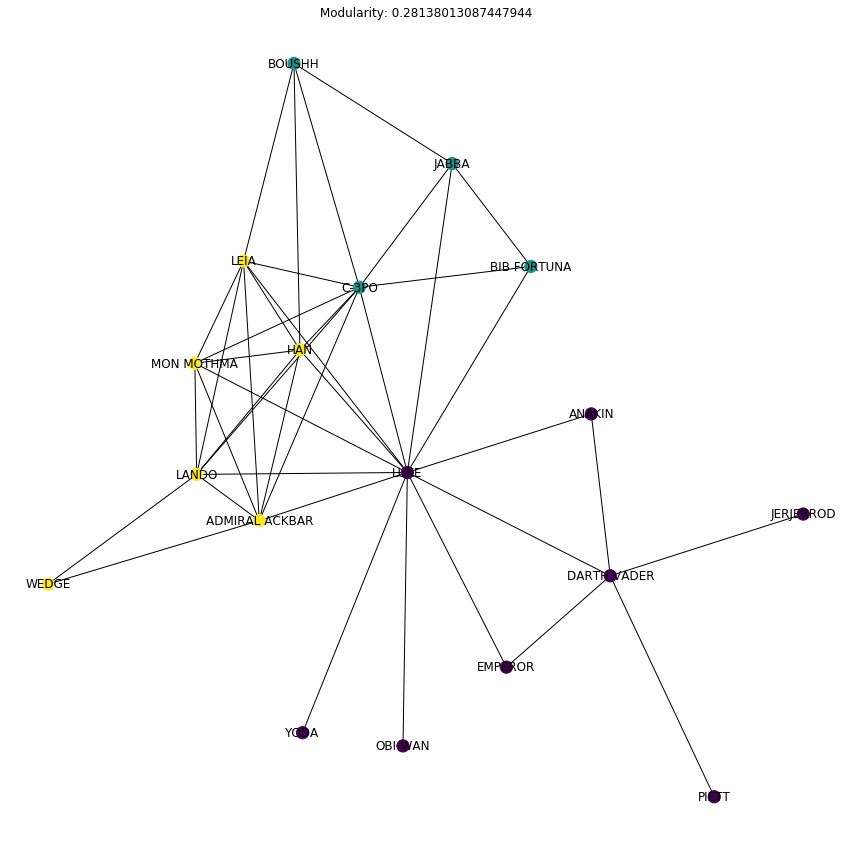

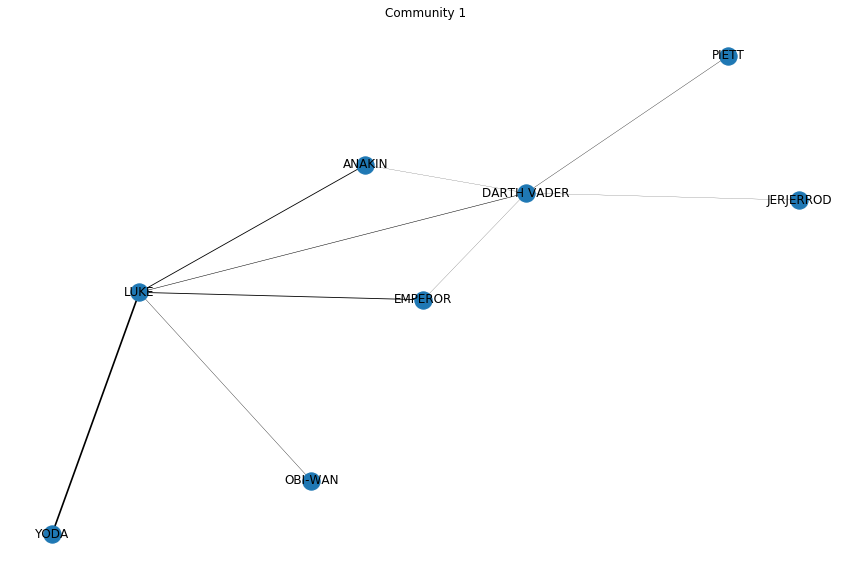

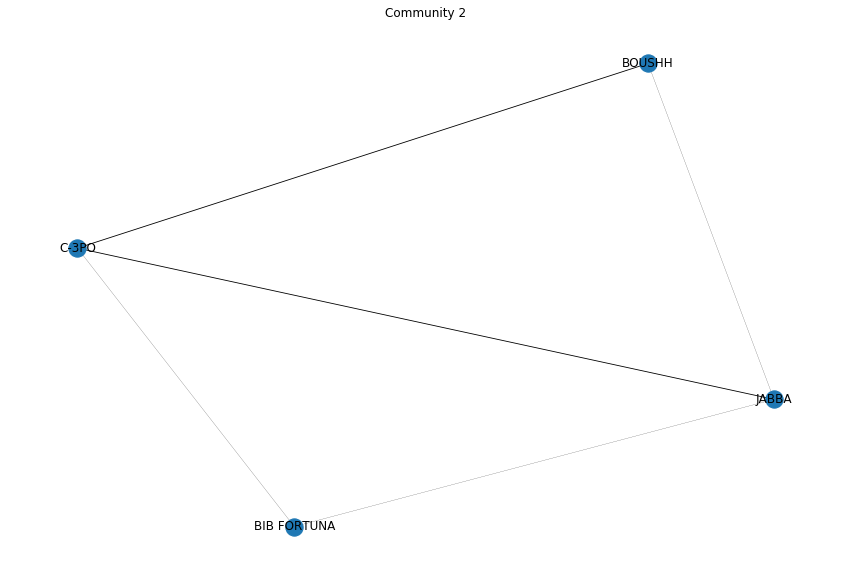

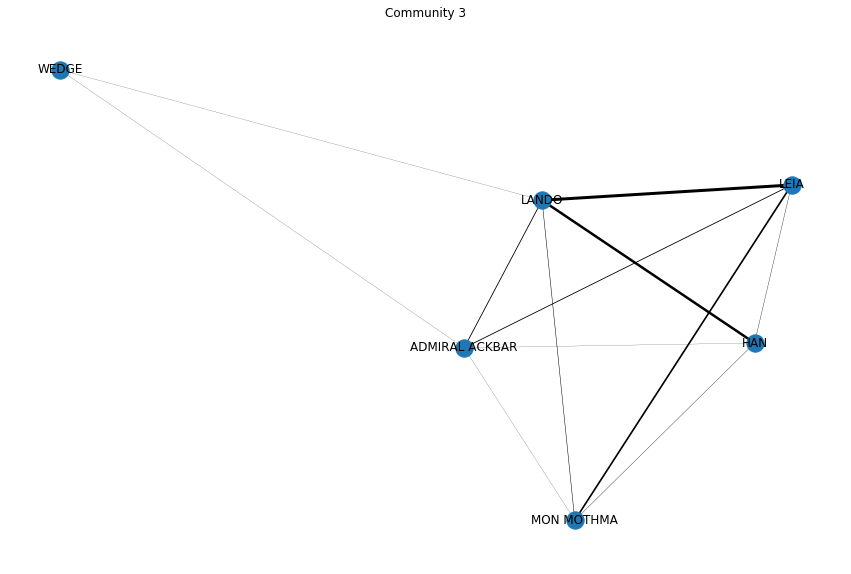

In [ ]:
random.seed(2)

coords6 = nx.kamada_kawai_layout(universe_ep6)

comm_all6 = community.best_partition(universe_ep6)
mod_all6 = community.modularity(comm_all6, universe_ep6)


options = {
    'node_color': list(comm_all6.values()),
    'node_size': 150,
    'width': 1,
    'with_labels': True,
    'pos': coords6
}

plt.figure(figsize=(15,15))
plt.title(f'Modularity: {mod_all6}')
nx.draw(universe_ep6, **options)

###------

edge_weights = list()
for (_, _, d) in universe_ep6.edges(data=True):
    edge_weights.append(d['value'])

pos = nx.spring_layout(universe_ep6)

for comm_num in np.unique(list(comm_all6.values())):
    partition = community.best_partition(universe_ep6)
    partition_nodes = list()
    for node, c in partition.items():
        if c == comm_num:
            partition_nodes.append(node)
        else:
            partition[node] = -1
    sub_universe = universe_ep6.subgraph(partition_nodes)
    edge_widths = (edge_weights / np.quantile(edge_weights, 0.85)).tolist()
    # Plot
    fig, ax = plt.subplots(figsize=(15,10))
    nx.draw(sub_universe, pos, with_labels=True, width=edge_widths)
    ax.set_title(f'Community {comm_num+1}');

In [ ]:
# Calculate Betweenness Centrality

betCent = nx.betweenness_centrality(universe_ep6)
#print(betCent)
sorted(betCent, key=betCent.get, reverse=True)[:5]

['LUKE', 'DARTH VADER', 'C-3PO', 'LANDO', 'ADMIRAL ACKBAR']

### Network-Analysis: Episode I – The Phantom Menace (1999)

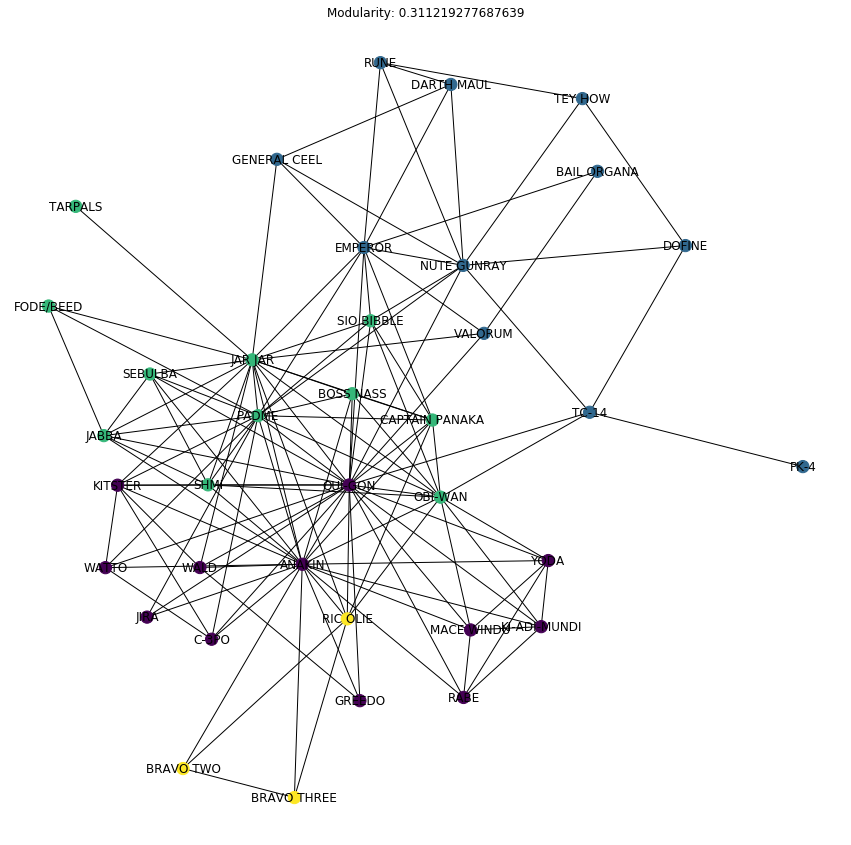

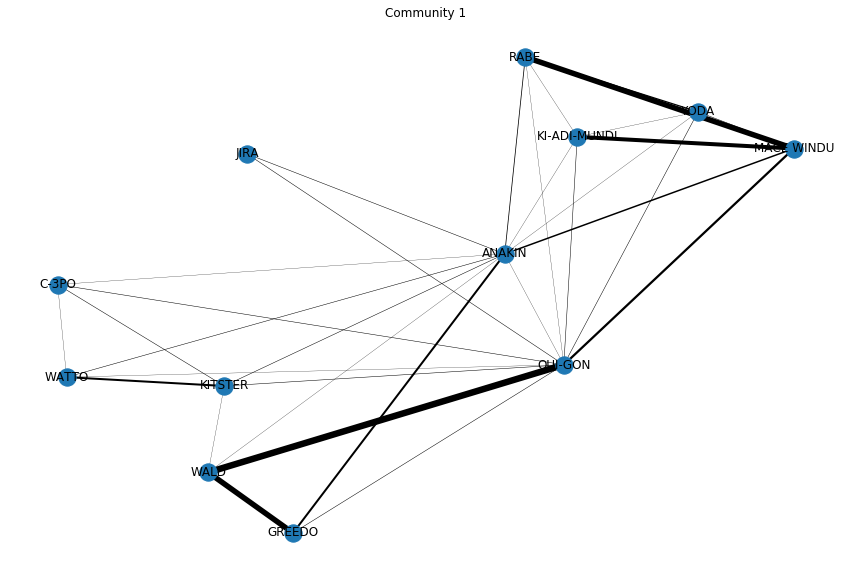

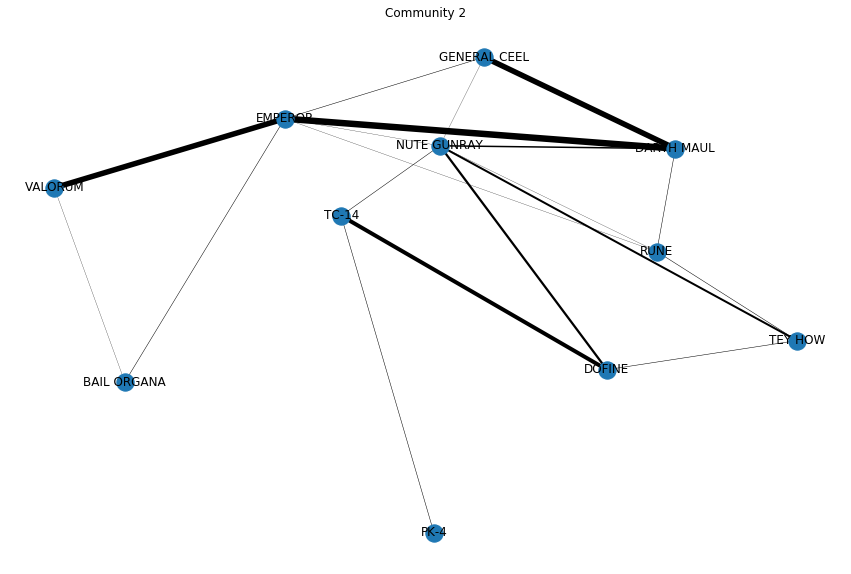

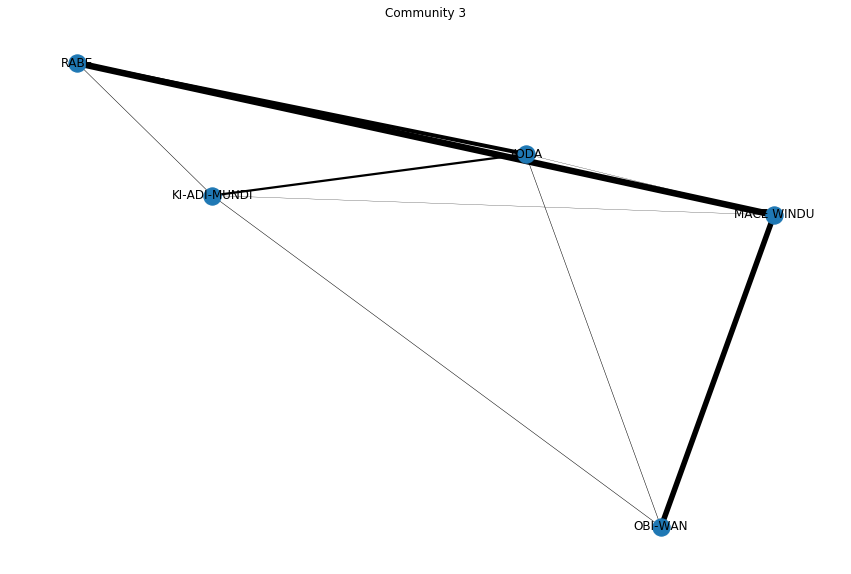

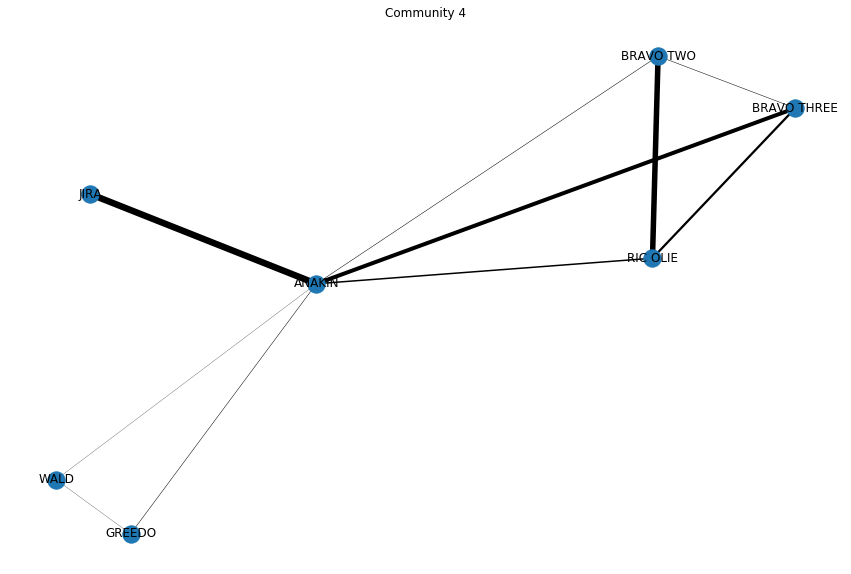

In [ ]:
random.seed(1)

coords1 = nx.kamada_kawai_layout(universe_ep1)
comm_all1 = community.best_partition(universe_ep1)
mod_all1 = community.modularity(comm_all1, universe_ep1)

options = {
    'node_color': list(comm_all1.values()),
    'node_size': 150,
    'width': 1,
    'with_labels': True,
    'pos': coords1
}

plt.figure(figsize=(15,15))
plt.title(f'Modularity: {mod_all1}')
nx.draw(universe_ep1, **options)

###------

edge_weights = list()
for (_, _, d) in universe_ep1.edges(data=True):
    edge_weights.append(d['value'])

pos = nx.spring_layout(universe_ep1)

for comm_num in np.unique(list(comm_all1.values())):
    partition = community.best_partition(universe_ep1)
    partition_nodes = list()
    for node, c in partition.items():
        if c == comm_num:
            partition_nodes.append(node)
        else:
            partition[node] = -1
    sub_universe = universe_ep1.subgraph(partition_nodes)
    edge_widths = (edge_weights / np.quantile(edge_weights, 0.85)).tolist()
    # Plot
    fig, ax = plt.subplots(figsize=(15,10))
    nx.draw(sub_universe, pos, with_labels=True, width=edge_widths)
    ax.set_title(f'Community {comm_num+1}');



In [ ]:
# Calculate Betweenness Centrality

betCent = nx.betweenness_centrality(universe_ep1)
#print(betCent)
sorted(betCent, key=betCent.get, reverse=True)[:5]

['QUI-GON', 'ANAKIN', 'JAR JAR', 'NUTE GUNRAY', 'EMPEROR']

### Network: Episode II – Attack of the Clones (2002)

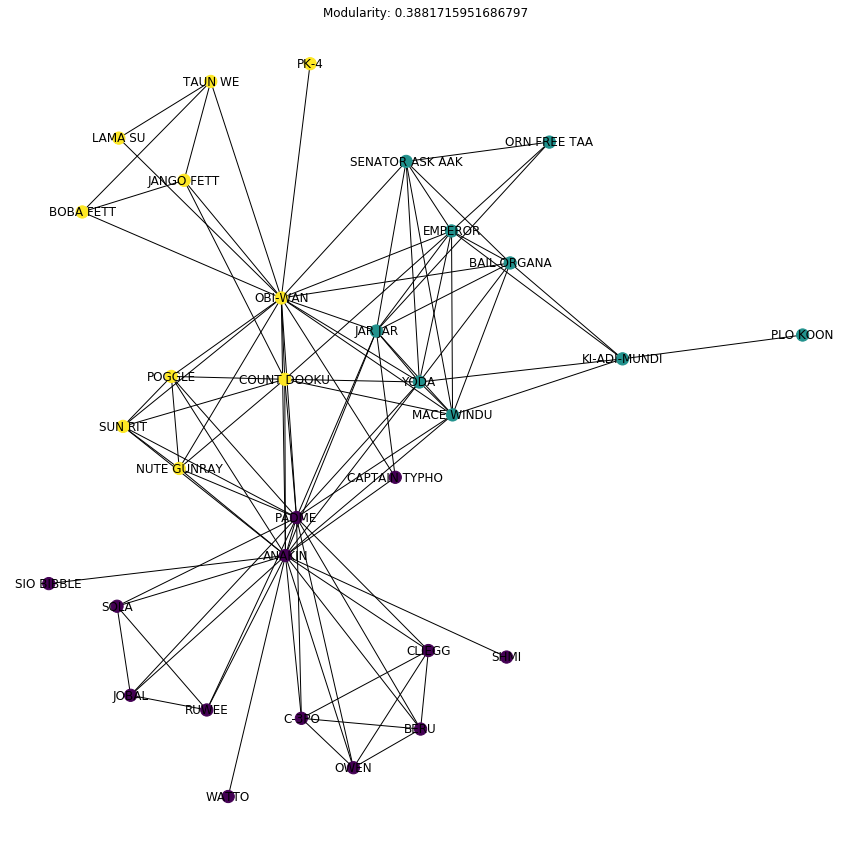

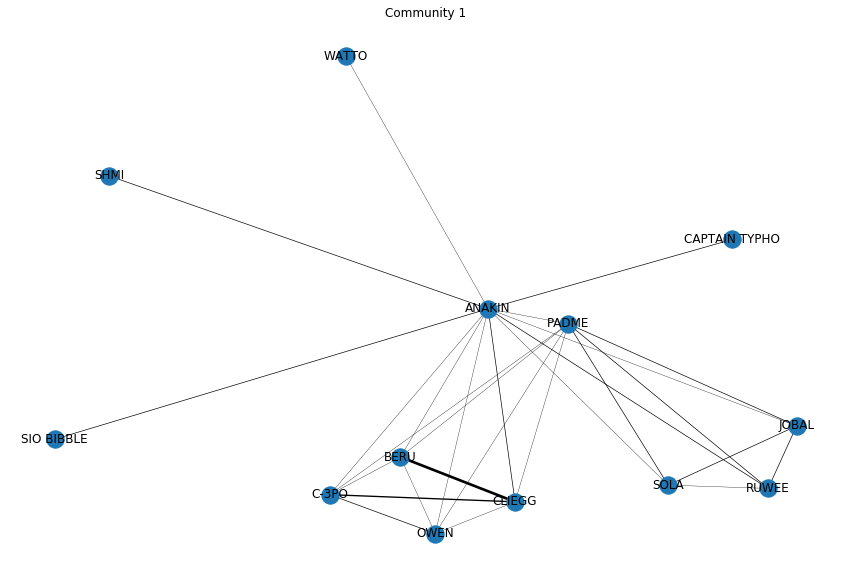

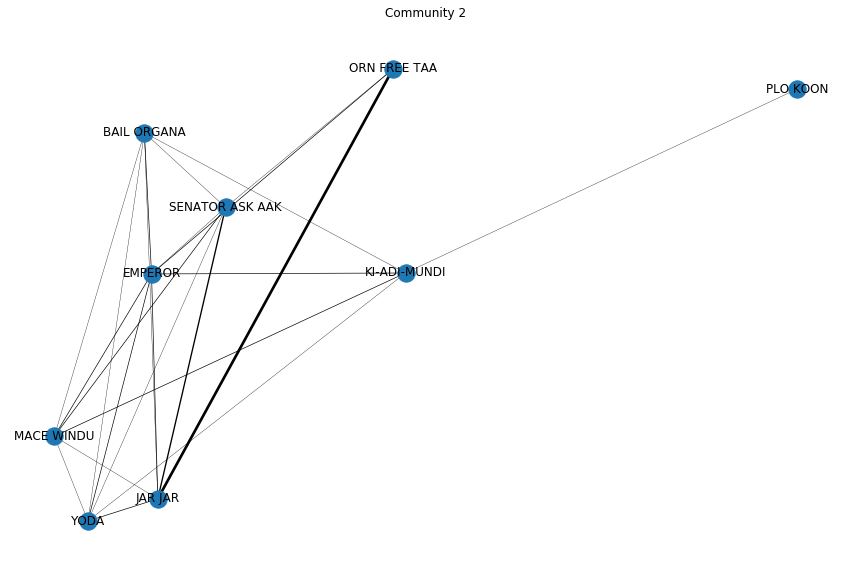

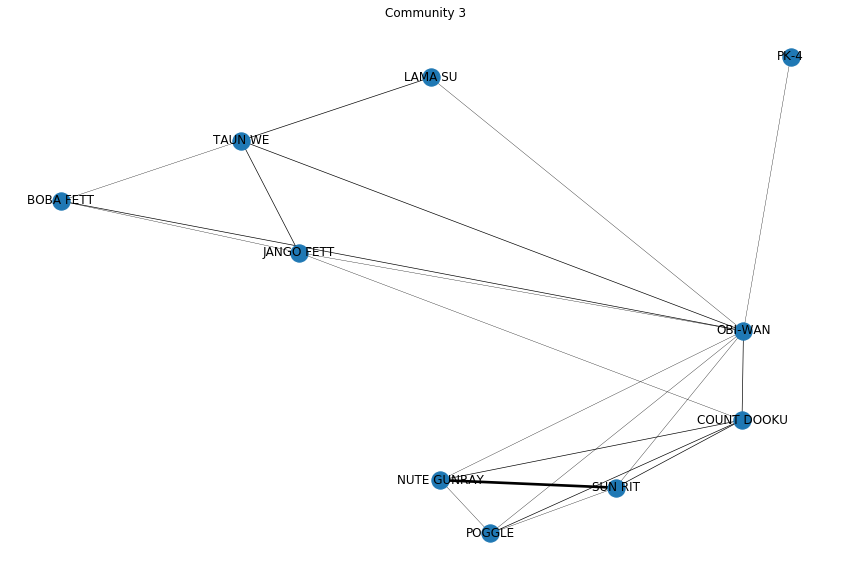

In [ ]:
random.seed(2)

coords2 = nx.kamada_kawai_layout(universe_ep2)
comm_all2 = community.best_partition(universe_ep2)
mod_all2 = community.modularity(comm_all2, universe_ep2)


options = {
    'node_color': list(comm_all2.values()),
    'node_size': 150,
    'width': 1,
    'with_labels': True,
    'pos': coords2
}

plt.figure(figsize=(15,15))
plt.title(f'Modularity: {mod_all2}')
nx.draw(universe_ep2, **options)

###------

edge_weights = list()
for (_, _, d) in universe_ep2.edges(data=True):
    edge_weights.append(d['value'])

pos = nx.spring_layout(universe_ep2)

for comm_num in np.unique(list(comm_all2.values())):
    partition = community.best_partition(universe_ep2)
    partition_nodes = list()
    for node, c in partition.items():
        if c == comm_num:
            partition_nodes.append(node)
        else:
            partition[node] = -1
    sub_universe = universe_ep2.subgraph(partition_nodes)
    edge_widths = (edge_weights / np.quantile(edge_weights, 0.85)).tolist()
    # Plot
    fig, ax = plt.subplots(figsize=(15,10))
    nx.draw(sub_universe, pos, with_labels=True, width=edge_widths)
    ax.set_title(f'Community {comm_num+1}');

In [ ]:
# Calculate Betweenness Centrality

betCent = nx.betweenness_centrality(universe_ep2)
#print(betCent)
sorted(betCent, key=betCent.get, reverse=True)[:5]

['ANAKIN', 'OBI-WAN', 'PADME', 'KI-ADI-MUNDI', 'JAR JAR']

### Network: Episode III – Revenge of the Sith

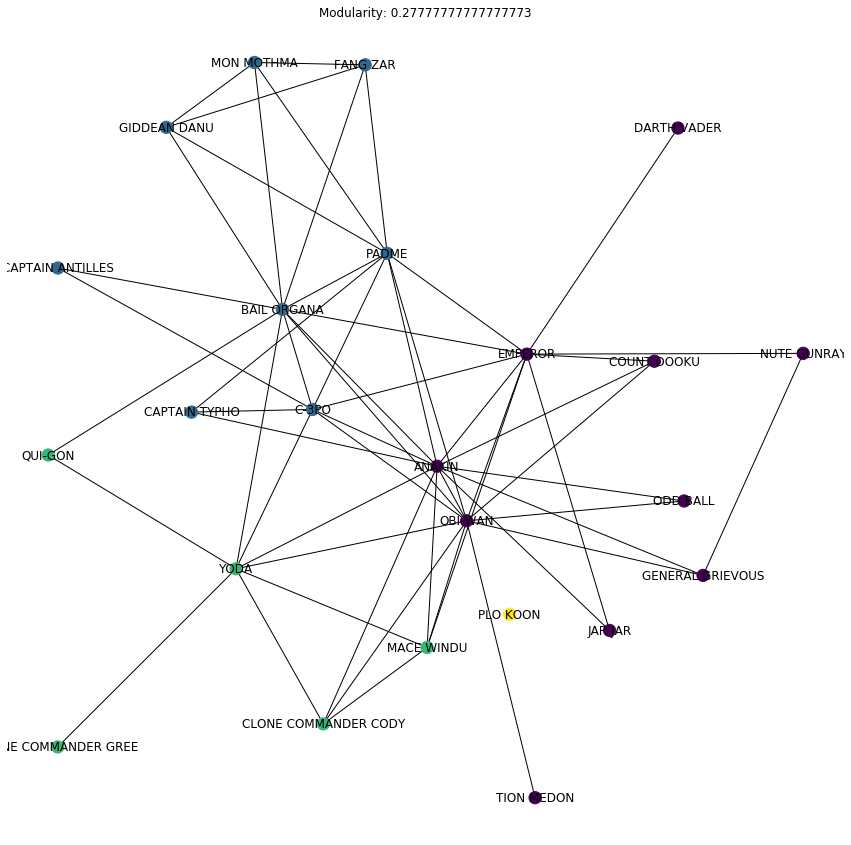

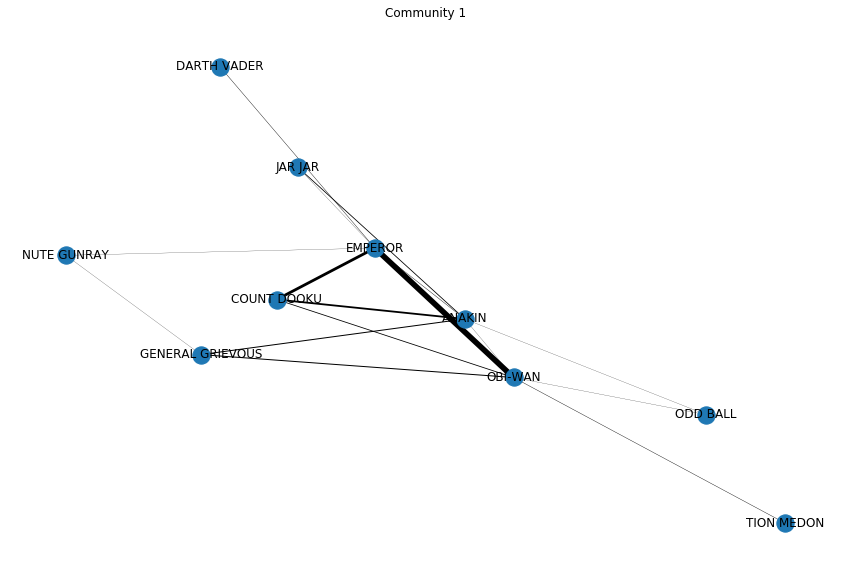

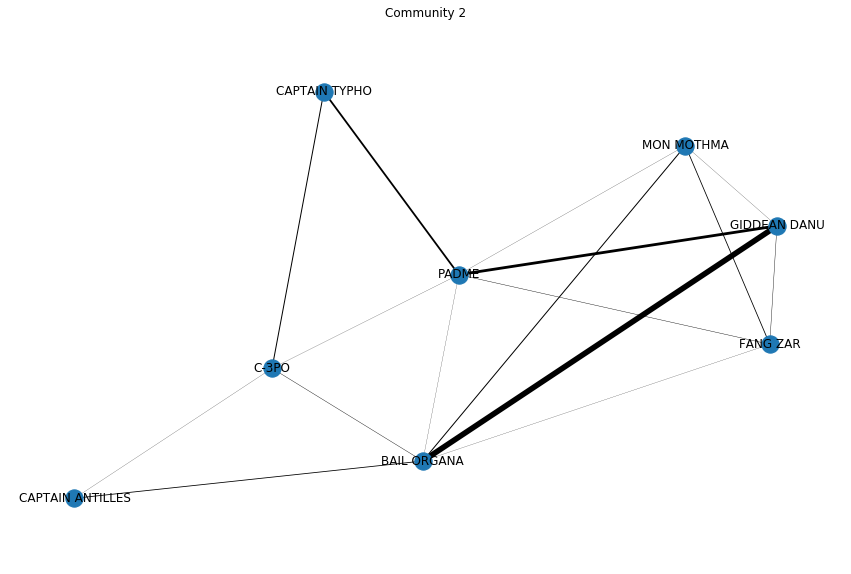

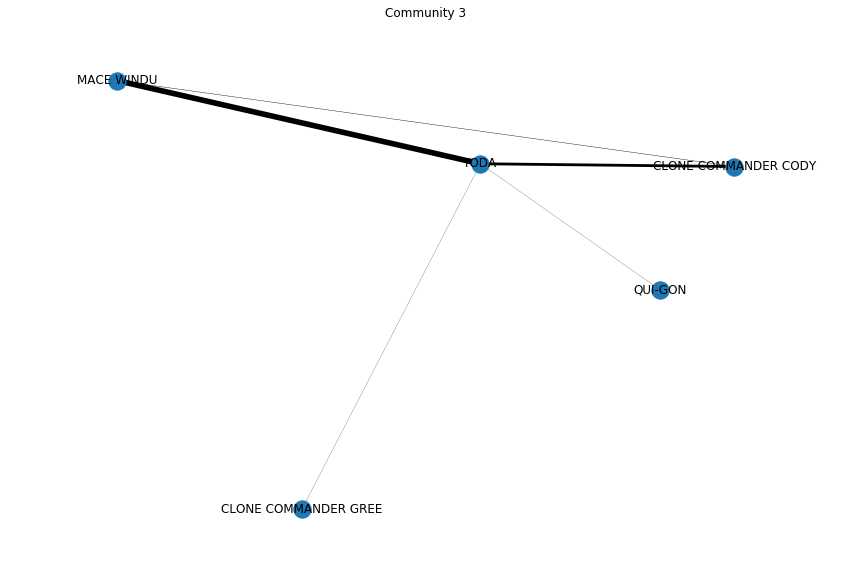

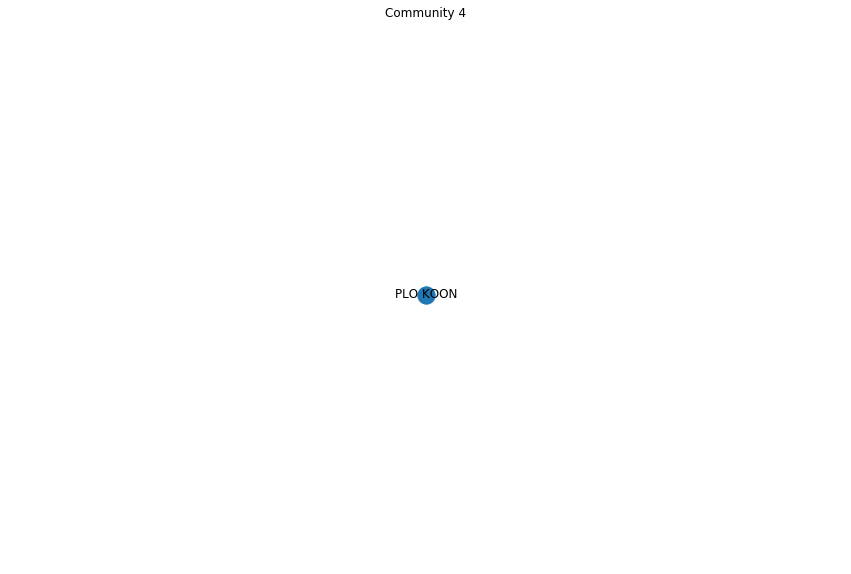

In [ ]:
random.seed(1)

coords3 = nx.kamada_kawai_layout(universe_ep3)
comm_all3 = community.best_partition(universe_ep3)
mod_all3 = community.modularity(comm_all3, universe_ep3)


options = {
    'node_color': list(comm_all3.values()),
    'node_size': 150,
    'width': 1,
    'with_labels': True,
    'pos': coords3
}

plt.figure(figsize=(15,15))
plt.title(f'Modularity: {mod_all3}')
nx.draw(universe_ep3, **options)

###------

edge_weights = list()
for (_, _, d) in universe_ep3.edges(data=True):
    edge_weights.append(d['value'])

pos = nx.spring_layout(universe_ep3)

for comm_num in np.unique(list(comm_all3.values())):
    partition = community.best_partition(universe_ep3)
    partition_nodes = list()
    for node, c in partition.items():
        if c == comm_num:
            partition_nodes.append(node)
        else:
            partition[node] = -1
    sub_universe = universe_ep3.subgraph(partition_nodes)
    edge_widths = (edge_weights / np.quantile(edge_weights, 0.85)).tolist()
    # Plot
    fig, ax = plt.subplots(figsize=(15,10))
    nx.draw(sub_universe, pos, with_labels=True, width=edge_widths)
    ax.set_title(f'Community {comm_num+1}');

In [ ]:
# Calculate Betweenness Centrality

betCent = nx.betweenness_centrality(universe_ep3)
#print(betCent)
sorted(betCent, key=betCent.get, reverse=True)[:5]

['BAIL ORGANA', 'OBI-WAN', 'ANAKIN', 'EMPEROR', 'YODA']

### Network: Episode VII (7) – The Force Awakens (2015) 

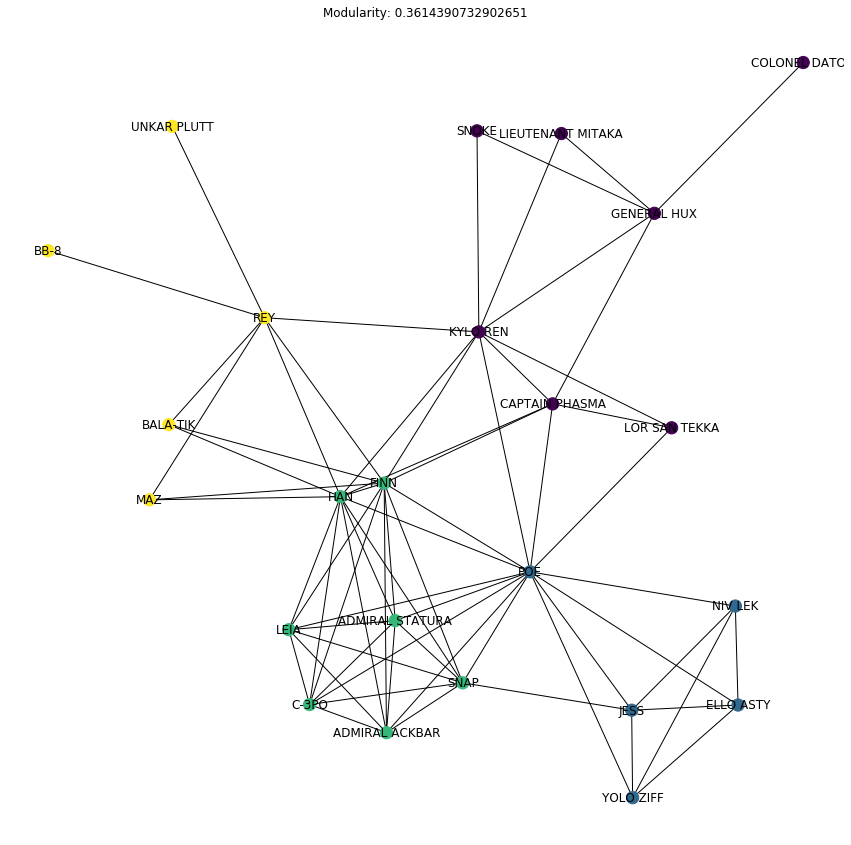

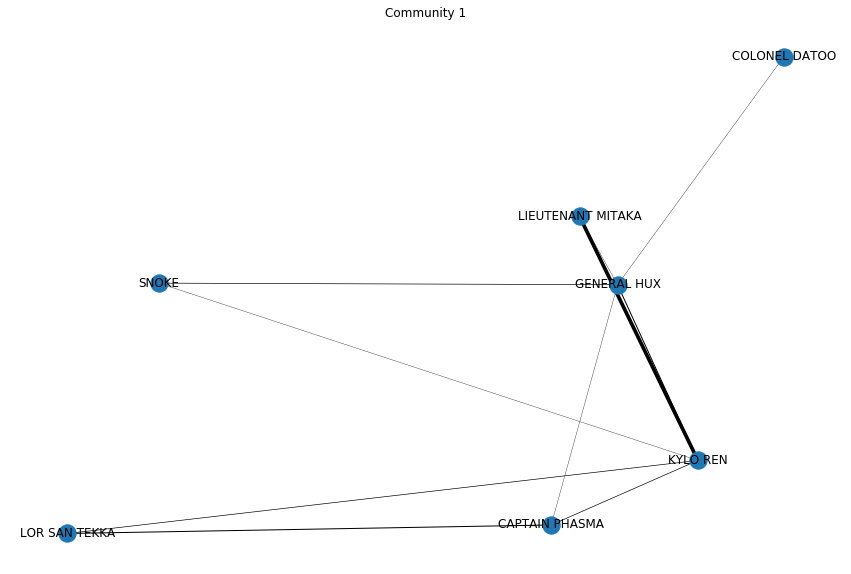

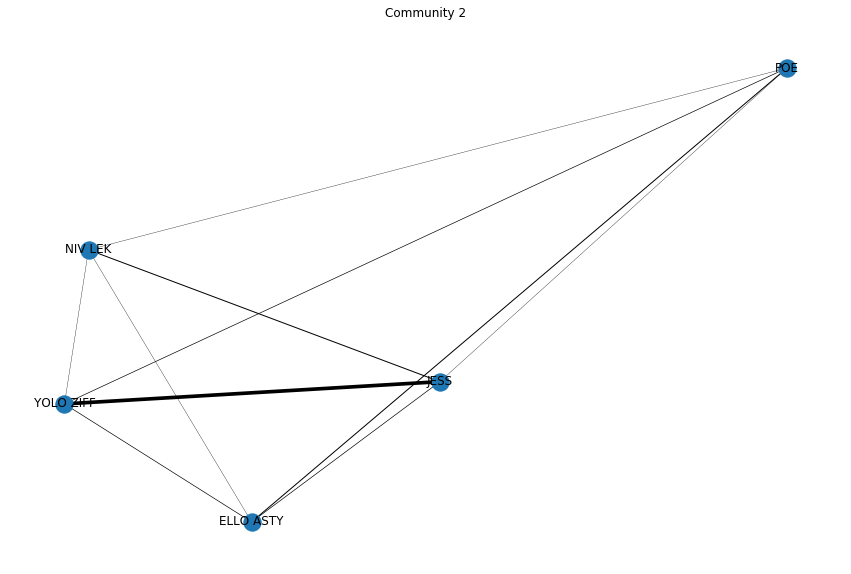

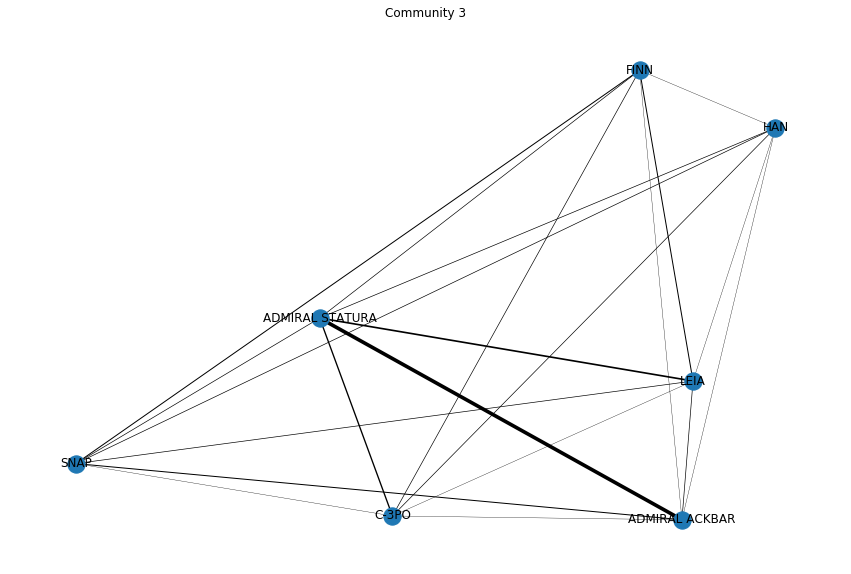

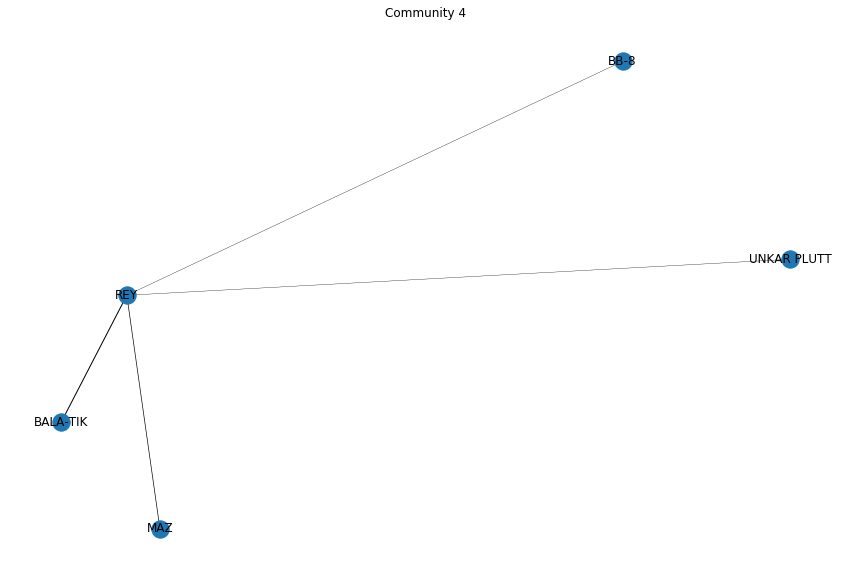

In [ ]:
random.seed(1)

coords7 = nx.kamada_kawai_layout(universe_ep7)
comm_all7 = community.best_partition(universe_ep7)
mod_all7 = community.modularity(comm_all7, universe_ep7)


options = {
    'node_color': list(comm_all7.values()),
    'node_size': 150,
    'width': 1,
    'with_labels': True,
    'pos': coords7
}

plt.figure(figsize=(15,15))
plt.title(f'Modularity: {mod_all7}')
nx.draw(universe_ep7, **options)

###------

edge_weights = list()
for (_, _, d) in universe_ep7.edges(data=True):
    edge_weights.append(d['value'])

pos = nx.spring_layout(universe_ep7)

for comm_num in np.unique(list(comm_all7.values())):
    partition = community.best_partition(universe_ep7)
    partition_nodes = list()
    for node, c in partition.items():
        if c == comm_num:
            partition_nodes.append(node)
        else:
            partition[node] = -1
    sub_universe = universe_ep7.subgraph(partition_nodes)
    edge_widths = (edge_weights / np.quantile(edge_weights, 0.85)).tolist()
    # Plot
    fig, ax = plt.subplots(figsize=(15,10))
    nx.draw(sub_universe, pos, with_labels=True, width=edge_widths)
    ax.set_title(f'Community {comm_num+1}');

## Conclusion

**Interpretation form of communities** 
- Partitions: There are always between 3-5 communities per episode.  Episode 4 has the most communities compared to the other episodes (5 communities).
- Hint: The communities are always very unsymmetrical / the central figure is not necessarily in the middle.

**Interpretation connections between communities (Modularity & Betweenness Centrality)**
- Modularity: The modularity fluctuates between 0.28-0.38 over the episodes, which is very low. This indicates weak community structures. 
Episode 2 with a modularity of 0.388 is the highest compared to the other episodes.
The network that takes all episodes into account has the highest modularity with 0.428.
- Betweenness Centrality: Across all episodes, 'OBI-WAN', 'C-3PO', 'ANAKIN', 'LUKE', 'HAN'
are the important characters for the cross-communication between Communtities. 




## Number of Communities vs. episode popularity 

Text(0, 0.5, 'Box Office Revenue (Wikipedia, 2020)')

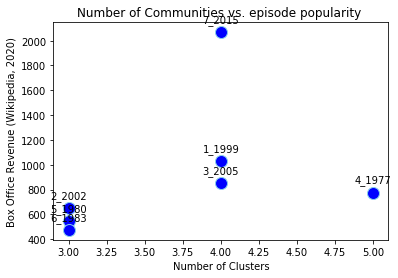

In [ ]:
data_vs = {"number_communities":[5,3,3,4,3,4,4],
        "episode":["4_1977", "5_1980","6_1983","1_1999","2_2002","3_2005","7_2015"],
        "popularity":[775, 547, 475, 1027, 649, 850, 2068]}


plt.plot("number_communities","popularity",data=data_vs, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=0)
for x,y,z in zip(data_vs["number_communities"],data_vs["popularity"],data_vs["episode"]):
    
    label = z

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.title('Number of Communities vs. episode popularity ')
plt.xlabel('Number of Clusters')
plt.ylabel('Box Office Revenue (Wikipedia, 2020)')

